In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Tiền xử lí dữ liệu
- Loại dữ liệu từ csv
- is null
- duplicate
- outlier

In [47]:
estate_data = pd.read_csv('data/vietnam_housing_dataset.csv')

In [48]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


In [49]:
estate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,30229.0,68.498741,48.069835,3.1,40.0,56.0,80.0,595.0
Frontage,18665.0,5.361692,4.346174,1.0,4.0,4.5,5.0,77.0
Access Road,16932.0,7.853800,7.451313,1.0,4.0,6.0,10.0,85.0
Floors,26626.0,3.410426,1.328897,1.0,2.0,3.0,4.0,10.0
Bedrooms,25067.0,3.511030,1.309116,1.0,3.0,3.0,4.0,9.0
Bathrooms,23155.0,3.346837,1.400181,1.0,2.0,3.0,4.0,9.0
Price,30229.0,5.872078,2.211877,1.0,4.2,5.9,7.5,11.5


In [50]:
estate_data.describe(exclude='number').T

,count,unique,top,freq
Address,30229,10265,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",187
House direction,8990,8,Đông - Nam,1916
Balcony direction,5246,8,Đông - Nam,1087
Legal status,25723,2,Have certificate,24774
Furniture state,16110,2,Full,10591


In [51]:
area_index = estate_data[(estate_data['Area'] > 150)].index
estate_data = estate_data.drop(area_index, axis=0)

frontage_index = estate_data[(estate_data['Frontage'] > 15)].index
estate_data = estate_data.drop(frontage_index, axis=0)

estate_data.shape

(28694, 12)

In [52]:
def extract_xa(address):
    if pd.isna(address):
        return None
    
    # Find part that contains Xã / Phường / Thị trấn
    match = re.search(r"(Xã|Phường|Thị trấn)\s+[^,]+", address, re.IGNORECASE)
    if match:
        return match.group(0).strip()
    return None


def extract_tinh(address):
    if pd.isna(address):
        return None
    
    # Always take the LAST comma-separated part
    parts = [p.strip() for p in address.split(",")]
    return parts[-1] if len(parts) > 0 else None


# Apply extraction
estate_data["xa_phuong"] = estate_data["Address"].apply(extract_xa)
estate_data["tinh_thanhpho"] = estate_data["Address"].apply(extract_tinh)

In [53]:
estate_data = estate_data.drop(['Balcony direction', 'House direction', 'Furniture state', 'Access Road', 'Address'], axis=1)

In [54]:
estate_data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
30224    False
30225    False
30226    False
30227    False
30228    False
Length: 28694, dtype: bool

In [55]:
legal_stat_categories = estate_data['Legal status'].astype('category').cat.categories
estate_data['Legal status'] = estate_data['Legal status'].astype('category').cat.codes

xa_categories = estate_data['xa_phuong'].astype('category').cat.categories
estate_data['xa_phuong'] = estate_data['xa_phuong'].astype('category').cat.codes

tinh_categories = estate_data['tinh_thanhpho'].astype('category').cat.categories
estate_data['tinh_thanhpho'] = estate_data['tinh_thanhpho'].astype('category').cat.codes

estate_data.head()

,Area,Frontage,Floors,Bedrooms,Bathrooms,Legal status,Price,xa_phuong,tinh_thanhpho
0,84.0,NaN,4.0,NaN,NaN,0,8.60,836,30
1,60.0,NaN,5.0,NaN,NaN,-1,7.50,868,30
2,90.0,6.0,5.0,NaN,NaN,1,8.90,868,30
3,54.0,NaN,2.0,2.0,3.0,0,5.35,15,36
4,92.0,NaN,2.0,4.0,4.0,0,6.90,37,36


# Phân tích mối quan hệ của các thuộc tính
- heatmap
- biểu đồ (cột/đường/top) -> sau mỗi biểu đồ cần 1 kết luận

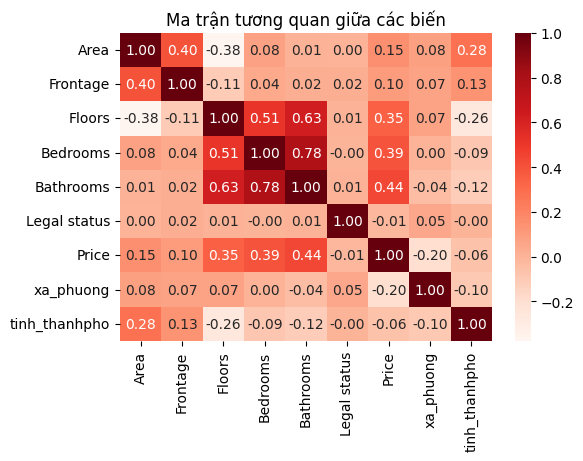

In [56]:
plt.figure(figsize=(6, 4))
sns.heatmap(estate_data.corr(), annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.title("Ma trận tương quan giữa các biến")
plt.show()

Text(0.5, 1.0, 'Frontage')

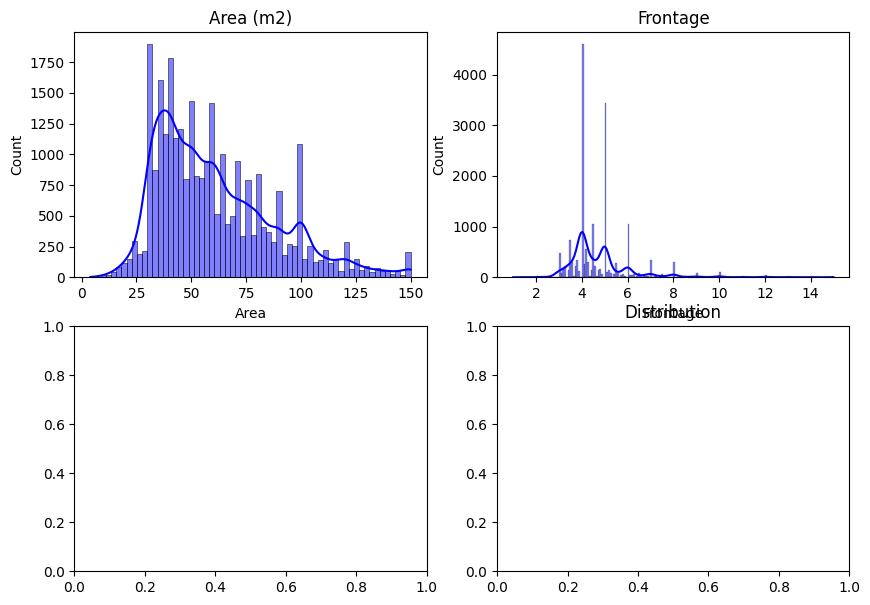

In [63]:
figure, axis = plt.subplots(2, 2, figsize=(10, 7))
plt.title("Distribution")

sns.histplot(data=estate_data, x=estate_data['Area'], kde=True, color='blue', ax=axis[0,0]).set_title("Area (m2)")
sns.histplot(data=estate_data, x=estate_data['Frontage'], kde=True, color='blue', ax=axis[0,1]).set_title("Frontage")

# Train - test - prediction
- Tạo mô hình
- Chia tập train - test
- Train (fit)
- Đánh giá mô hình với R^2 + MSE với tập test
- Dự đoán (có thể vẽ mô hình)